
# Math 432 Lab: Gradient Descent via Linear Regression

## Learning objectives
By the end of this lab you will be able to:
- Write the linear regression model in linear algebra form.
- Derive and implement the mean squared error (MSE) gradient.
- Implement batch gradient descent and diagnose convergence via the learning rate $\eta$.
- Compare gradient descent to the closed-form normal equation solution.



## 0. Imports and utility style
(Run this cell first.)


In [48]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 11



## 1. Toy dataset (univariate)
We'll use a tiny dataset that makes it easy to visualize and debug.

Points: $(1,2)$, $(2,1)$, $(3,3)$, $(4,2)$, $(5,4)$.


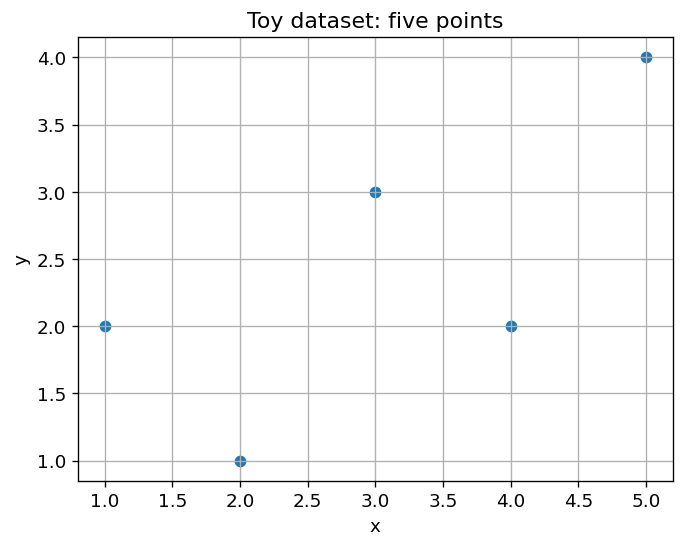

In [49]:

# Data
x = np.array([1., 2., 3., 4., 5.])[:, None]  # shape (n,1)
y = np.array([2., 1., 3., 2., 4.])[:, None]  # shape (n,1)
n = x.shape[0]

# Design matrix with a bias column of ones: X_tilde = [x, 1]
X = np.hstack([x, np.ones_like(x)])  # shape (n,2); columns are [x, 1]

fig, ax = plt.subplots()
ax.scatter(x, y, color='C0')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Toy dataset: five points')
plt.show()



## 1.5. Warm-up: $J(w_1, b)$ on the toy dataset (scalar view)
We will start by working with scalars. Our model is $\hat y_i = w_1 x_i + b$ and the cost is
$$
J(w_1,b) = \frac{1}{n} \sum_{i=1}^n (w_1 x_i + b - y_i)^2.
$$
Use the five points given above.

### Exercise A — Evaluate $J(w_1,b)$ at a few guesses
By hand (and then with code), compute $J(w_1,b)$ for these settings: $(w_1,b) \in \{(0,0), (1,0), (0,1)\}$.  
Which one gives the smallest value?

### Exercise B — Compute the partial derivatives at $(w_1,b)=(0,0)$
Find (by hand) formulas for the partial derivatives $\frac{\partial J}{\partial w_1}$ and $\frac{\partial J}{\partial b}$.

_Hint_: The loss function is a big sum. Differentiate term by term.

Using the dataset, compute the partial derivatives **by hand** at $(w_1,b)=(0,0)$.

A table may help you organize the computation at $(w_1,b)=(0,0)$ (so $\hat y_i = 0$):

| $i$ | $x_i$ | $y_i$ | $\hat y_i$ | $r_i=\hat y_i-y_i$ | $r_i x_i$ |
|---:|---:|---:|---:|---:|---:|
| 1 | 1 | 2 | 0 | -2 | -2 |
| 2 | 2 | 1 | 0 | -1 | -2 |
| 3 | 3 | 3 | 0 | -3 | -9 |
| 4 | 4 | 2 | 0 | -2 | -8 |
| 5 | 5 | 4 | 0 | -4 | -20 |

**Reflection.** If $\tfrac{\partial J}{\partial w_1} > 0$ at $(w_1,b)=(0,0)$, should the next step of gradient descent increase or decrease $w_1$? Briefly explain.

**Answer** It should decrease $w_1$ because the point of the gradient descent is that it points you in the direction to increase J, which is the opposite of what we want to do.


In [50]:

# Exercise A (code) — Implement J(w1,b) using *sums* (no matrix multiplications)
# Return J(w1,b) = (1/n) * sum_i (w1*x_i + b - y_i)^2

# Implement with sums to mirror the by-hand computation.
def J_scalar(w1: float, b: float, x: np.ndarray, y: np.ndarray) -> float:
    n = x.shape[0]
    # TODO:
    sum = 0
    index = 0
    while index < n:
        sum = sum + (w1*x[index] + b - y[index])**2
        index = index + 1
    return sum / n
    raise NotImplementedError('Fill in J_scalar')

# After implementing J_scalar, evaluate it for the three guesses (and some others, if you like):
for (w1,b) in [(0,0),(1,0),(0,1)]:
    print((w1,b), '-> J =', J_scalar(w1,b,x,y))


(0, 0) -> J = [6.8]
(1, 0) -> J = [1.4]
(0, 1) -> J = [3.]


In [51]:

# Exercise B (code) — Compute the partials at (w1,b)=(0,0) using sums
w1, b = 0.0, 0.0
n = x.shape[0]
# TODO: compute residuals r_i = (w1*x_i + b - y_i) and the two sums
# r = w1 * x + b - y    ### the derivatives can be written in terms of this residual vector
index = 0
dJ_dw1 = 0
dJ_db = 0
while index < n:
    r = w1 * x[index] + b - y[index]
    dJ_dw1 = dJ_dw1 + (r * x[index])
    dJ_db = dJ_db + r
    index = index + 1
dJ_dw1 = 2 * dJ_dw1 / n
dJ_db = 2 * dJ_db / n

print('dJ/dw1 at (0,0) =', float(dJ_dw1))
print('dJ/db  at (0,0) =', float(dJ_db))


dJ/dw1 at (0,0) = -16.4
dJ/db  at (0,0) = -4.8


/var/folders/dm/tz6zgw7s7_982bxv844_t_v80000gn/T/ipykernel_21471/2890879119.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('dJ/dw1 at (0,0) =', float(dJ_dw1))
/var/folders/dm/tz6zgw7s7_982bxv844_t_v80000gn/T/ipykernel_21471/2890879119.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('dJ/db  at (0,0) =', float(dJ_db))



## 2. Model and loss (linear algebra)
We model $\hat{\mathbf{y}} = X\mathbf{w}$ where $X = [\mathbf{x}, \mathbf{1}] \in \mathbb{R}^{n\times 2}$ and $\mathbf{w} = \begin{bmatrix} w_1 \\ b \end{bmatrix}$.

The mean squared error (with the standard $1/n$ factor) is
$$J(\mathbf{w}) = \frac{1}{n}\,\lVert X\mathbf{w} - \mathbf{y} \rVert_2^2 = \frac{1}{n}(X\mathbf{w} - \mathbf{y})^T (X\mathbf{w} - \mathbf{y}).$$
Its gradient is
$$\nabla J(\mathbf{w}) = \frac{2}{n} X^T (X\mathbf{w} - \mathbf{y}).$$

**Gradient descent update:**  $\mathbf{w}^{k+1} = \mathbf{w}^{k} - \eta\, \nabla J(\mathbf{w}^{k})$.



### Exercise 1 — Derive and code the *scalar* partial derivatives (general $(w_1,b)$)
Show that
$$\frac{\partial J}{\partial w_1} = \frac{2}{n} \sum_{i=1}^n (w_1 x_i + b - y_i) x_i,\qquad \frac{\partial J}{\partial b} = \frac{2}{n} \sum_{i=1}^n (w_1 x_i + b - y_i).$$
Then implement these formulas below as a function.


In [52]:

# Return (dJ/dw1, dJ/db) using the scalar summation formulas.
def partials_manual(w1: float, b: float, x: np.ndarray, y: np.ndarray):
    n = x.shape[0]
    dJ_dw1 = 0
    dJ_db = 0
    # iterate through x and y to calculate partials
    for x_val, y_val in zip(x, y):
        dJ_dw1 = dJ_dw1 + ((w1*x_val + b - y_val) * x_val)
        dJ_db = dJ_db + (w1*x_val + b - y_val)

    dJ_db  = (2/n) * dJ_db
    dJ_dw1 = (2/n) * dJ_dw1
    return float(dJ_dw1), float(dJ_db)
    raise NotImplementedError('Fill in partials_manual')

# Quick smoke test (won't run until you implement):
partials_manual(0.0, 0.0, x, y)


/var/folders/dm/tz6zgw7s7_982bxv844_t_v80000gn/T/ipykernel_21471/605813314.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(dJ_dw1), float(dJ_db)


(-16.400000000000002, -4.800000000000001)


## 3. Vectorized gradient and consistency check
Using the linear algebra gradient $\nabla J(\mathbf{w}) = \frac{2}{n} X^T (X\mathbf{w} - \mathbf{y})$, implement a vectorized gradient function and verify that it matches your manual partials.


In [53]:

# Vectorized gradient and utilities
def grad_vectorized(w: np.ndarray, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    n = X.shape[0]
    return (2/n) * X.T @ (X @ w - y)

def mse_loss(w: np.ndarray, X: np.ndarray, y: np.ndarray) -> float:
    r = X @ w - y
    return float((r.T @ r) / X.shape[0])

def manual_vs_vectorized_check(w1, b):
    wvec = np.array([[w1],[b]])
    g_vec = grad_vectorized(wvec, X, y)
    dw1_man, db_man = partials_manual(w1, b, x, y)
    return g_vec.ravel(), np.array([dw1_man, db_man])

# Try a few random (w1,b) after you implement both functions: 
for w1 in [0.0, 0.5, -0.3]:
    for b in [0.0, 1.0, -1.0]:
        g_vec, g_man = manual_vs_vectorized_check(w1, b)
        print((w1,b), 'vectorized:', g_vec, 'manual:', g_man)
        assert np.allclose(g_vec, g_man, atol=1e-10)
print('✅ Manual and vectorized gradients match!')


(0.0, 0.0) vectorized: [-16.4  -4.8] manual: [-16.4  -4.8]
(0.0, 1.0) vectorized: [-10.4  -2.8] manual: [-10.4  -2.8]
(0.0, -1.0) vectorized: [-22.4  -6.8] manual: [-22.4  -6.8]
(0.5, 0.0) vectorized: [-5.4 -1.8] manual: [-5.4 -1.8]
(0.5, 1.0) vectorized: [0.6 0.2] manual: [0.6 0.2]
(0.5, -1.0) vectorized: [-11.4  -3.8] manual: [-11.4  -3.8]
(-0.3, 0.0) vectorized: [-23.   -6.6] manual: [-23.   -6.6]
(-0.3, 1.0) vectorized: [-17.   -4.6] manual: [-17.   -4.6]
(-0.3, -1.0) vectorized: [-29.   -8.6] manual: [-29.   -8.6]
✅ Manual and vectorized gradients match!


/var/folders/dm/tz6zgw7s7_982bxv844_t_v80000gn/T/ipykernel_21471/605813314.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(dJ_dw1), float(dJ_db)



### (Optional) Numerical gradient check
Use finite differences to sanity-check $\nabla J(w)$ at a random point.


In [54]:

# Finite-difference gradient
def numerical_grad(w: np.ndarray, X: np.ndarray, y: np.ndarray, eps: float = 1e-6):
    g = np.zeros_like(w)
    for j in range(w.size):
        e = np.zeros_like(w)
        e[j,0] = eps
        loss_plus  = mse_loss(w + e, X, y)
        loss_minus = mse_loss(w - e, X, y)
        g[j,0] = (loss_plus - loss_minus) / (2*eps)
    return g

# After you implement grad_vectorized: 
rng = np.random.default_rng(0)
w0 = rng.normal(size=(2,1))
g_num = numerical_grad(w0, X, y)
g_vec = grad_vectorized(w0, X, y)
print('numerical:', g_num.ravel(), 'vectorized:', g_vec.ravel())
assert np.allclose(g_num, g_vec, atol=1e-6)
print('✅ Numerical and analytic gradients agree')


numerical: [-14.4266  -4.3098] vectorized: [-14.4266  -4.3098]
✅ Numerical and analytic gradients agree


/var/folders/dm/tz6zgw7s7_982bxv844_t_v80000gn/T/ipykernel_21471/3572895110.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float((r.T @ r) / X.shape[0])



## 4. Implement batch gradient descent
We'll minimize $J(w)$ using the update $w^{k+1} = w^{k} - \eta\, \nabla J(w^{k})$.

**Exercise 2.** Complete the update step in the function below. Record the loss history for plotting.


In [55]:

# Batch gradient descent
def gradient_descent(w0: np.ndarray, X: np.ndarray, y: np.ndarray, eta: float, iters: int):
    w = w0.copy()
    history = {'w': [], 'loss': []}
    for k in range(iters):
        # TODO: compute gradient and perform the GD update
        g = grad_vectorized(w, X, y)
        history['w'].append(w.copy())
        history['loss'].append(mse_loss(w, X, y))
        w = w - eta * g
        # Record history
    return w, history

# Example (after you finish grad_vectorized and the update):
w0 = np.array([[0.0],[0.0]])
w_hat, hist = gradient_descent(w0, X, y, eta=0.05, iters=200)
w_hat, hist['loss'][-1]


/var/folders/dm/tz6zgw7s7_982bxv844_t_v80000gn/T/ipykernel_21471/3572895110.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float((r.T @ r) / X.shape[0])


(array([[0.5065],
        [0.8766]]),
 0.5401028711747156)


## 5. Visualizing convergence and the fitted line
Run gradient descent with a reasonable learning rate and plot the loss vs. iteration and the fitted line vs. data.


w via GD ≈ [0.5065 0.8766]


/var/folders/dm/tz6zgw7s7_982bxv844_t_v80000gn/T/ipykernel_21471/3572895110.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float((r.T @ r) / X.shape[0])


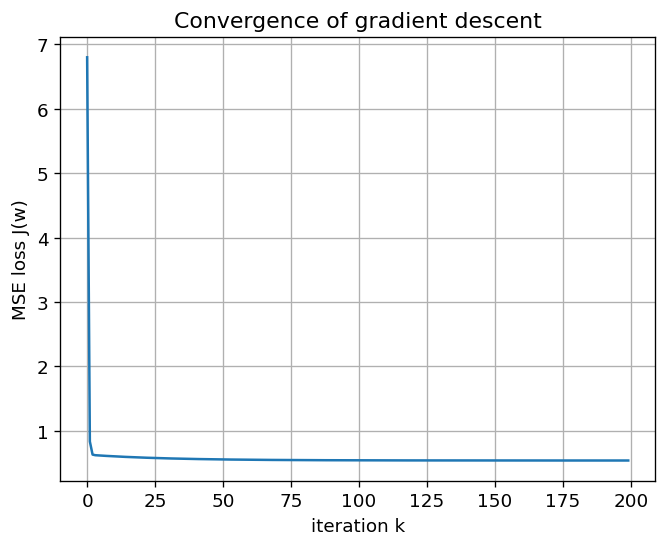

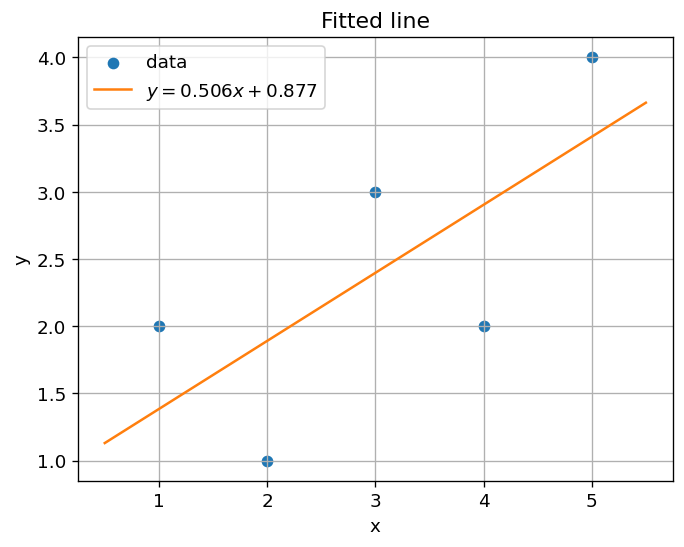

In [56]:

# Plot helpers
def plot_fit(w: np.ndarray, x: np.ndarray, y: np.ndarray):
    w1, b = float(w[0,0]), float(w[1,0])
    xs = np.linspace(x.min()-0.5, x.max()+0.5, 100)
    ys = w1*xs + b
    fig, ax = plt.subplots()
    ax.scatter(x, y, color='C0', label='data')
    ax.plot(xs, ys, color='C1', label=f'$y = {w1:.3f}x + {b:.3f}$')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Fitted line')
    ax.legend()
    plt.show()

def plot_loss(history):
    fig, ax = plt.subplots()
    ax.plot(history['loss'])
    ax.set_xlabel('iteration k')
    ax.set_ylabel('MSE loss J(w)')
    ax.set_title('Convergence of gradient descent')
    plt.show()

# After implementing gradient_descent:
w0 = np.array([[0.0],[0.0]])
w_gd, hist = gradient_descent(w0, X, y, eta=0.05, iters=200)
print('w via GD ≈', w_gd.ravel())
plot_loss(hist)
plot_fit(w_gd, x, y)



## 6. How the learning rate $\eta$ affects gradient descent
We'll sweep over several $\eta$ values and compare convergence.

**Exercise 3.** Try at least these values: $\eta \in \{0.001, 0.01, 0.05, 0.08, 0.1, 0.3\}$.
- Plot loss vs. iteration on the same axes.
- Note which settings are **too small** (very slow), **just right**, and **too large** (oscillation/divergence).

*Hint:* Use a fixed number of iterations (e.g., 300–500) and the same starting $w_0$ for fairness.


/var/folders/dm/tz6zgw7s7_982bxv844_t_v80000gn/T/ipykernel_21471/3572895110.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float((r.T @ r) / X.shape[0])


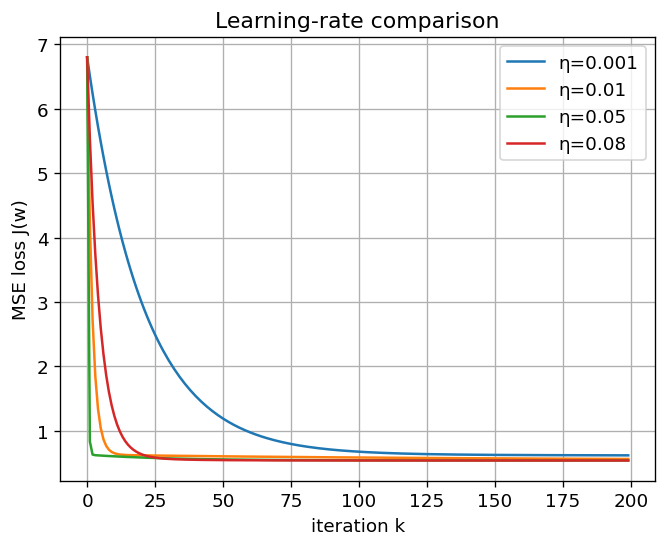

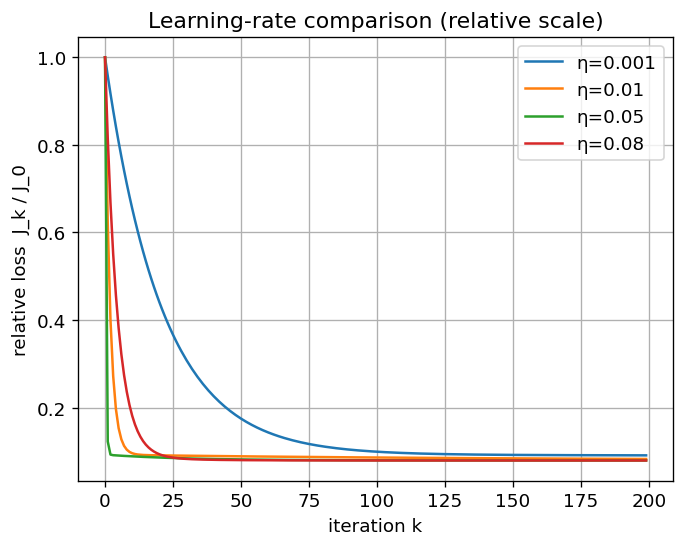

In [57]:

# Run and visualize many learning rates
def run_many_etas(etas, iters=400, w0=None):
    if w0 is None:
        w0 = np.array([[0.0],[0.0]])
    histories = {}
    for eta in etas:
        w_hat, hist = gradient_descent(w0, X, y, eta=eta, iters=iters)
        histories[eta] = hist
    return histories

def plot_many_losses(histories):
    fig, ax = plt.subplots()
    for eta, hist in histories.items():
        ax.plot(hist['loss'], label=f'η={eta}')
    ax.set_xlabel('iteration k')
    ax.set_ylabel('MSE loss J(w)')
    ax.set_title('Learning-rate comparison')
    ax.legend()
    plt.show()

### Can plot J_k / J_0 so that different loss functions can appear easily
### on the same plot

def plot_many_losses_relative(histories):
    fig, ax = plt.subplots()
    for eta, hist in histories.items():
        loss = np.asarray(hist['loss'], dtype=float)
        m = np.isfinite(loss) & (loss >= 0)
        if not np.any(m): 
            ax.plot([], [], label=f'η={eta} (no finite data)')
            continue
        loss = loss[m]
        iters = np.flatnonzero(m)
        if loss[0] == 0:
            # Avoid divide-by-zero; skip or add tiny epsilon
            eps = 1e-12
            loss_rel = loss / (loss[0] + eps)
        else:
            loss_rel = loss / loss[0]
        ax.plot(iters, loss_rel, label=f'η={eta}')
    ax.set_xlabel('iteration k')
    ax.set_ylabel('relative loss  J_k / J_0')
    ax.set_title('Learning-rate comparison (relative scale)')
    ax.legend()
    plt.show()


# Example usage (after finishing gradient_descent):
etas = [0.001, 0.01, 0.05, 0.08]    ### what happens if you add 0.1? what about 0.5?
histories = run_many_etas(etas, iters=200)
plot_many_losses(histories)
plot_many_losses_relative(histories)



### Discussion prompts
- What qualitative behaviors do you observe as $\eta$ increases? 

The loss function becomes steeper.
- Estimate a rough *stable* range of $\eta$ for this dataset. 

Between 0.001 and 0.05 seems to be the best and most stable range of $\eta$ for this dataset
- If we scaled $x$ by a factor of 100, how would that change a good choice of $\eta$? Why? 

The gradient would become dramatically steeper, so we would have to choose a much smaller $\eta$ to avoid overshooting the minimum.


## 7. Closed-form solution (for comparison)
Linear regression with a bias can be written with an augmented design matrix $X = [\textbf{x} \; \mathbf{1}]$. The minimizer is the normal-equation solution
$$\textbf{w}^{*} = (X^T X)^{-1} X^T \textbf{y},$$
provided $X^T X$ is invertible. Let's compute it and compare to your GD result.


/var/folders/dm/tz6zgw7s7_982bxv844_t_v80000gn/T/ipykernel_21471/3572895110.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float((r.T @ r) / X.shape[0])


w* via normal equation = [0.5 0.9]
MSE at w* = 0.54


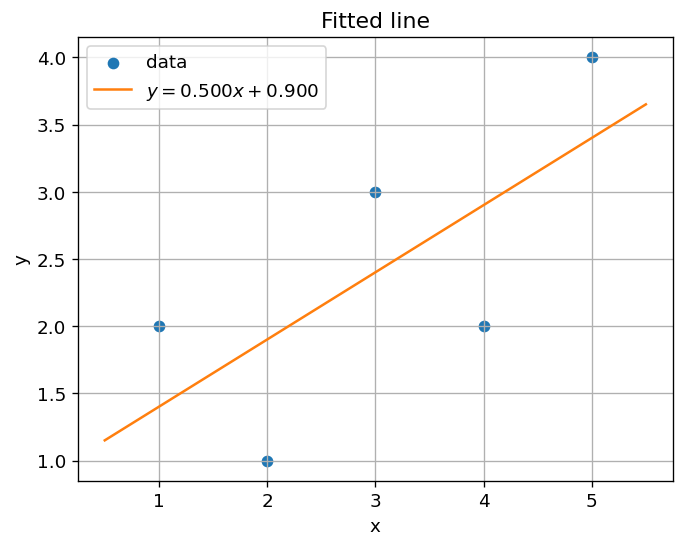

In [58]:

# Normal equation solution
def normal_equation(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    XtX = X.T @ X
    Xty = X.T @ y
    w_star = np.linalg.solve(XtX, Xty)
    return w_star

w_star = normal_equation(X, y)
print('w* via normal equation =', w_star.ravel())
print('MSE at w* =', mse_loss(w_star, X, y))
plot_fit(w_star, x, y)



## 8. Feature-scaling experiment
Scale $\mathbf{x}$ by a constant (e.g., 100) and re-run the $\eta$ sweep. Observe how the condition number of $X^T X$ affects the stable step sizes and convergence rate.


/var/folders/dm/tz6zgw7s7_982bxv844_t_v80000gn/T/ipykernel_21471/3572895110.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float((r.T @ r) / X.shape[0])
/var/folders/dm/tz6zgw7s7_982bxv844_t_v80000gn/T/ipykernel_21471/3572895110.py:8: RuntimeWarning: overflow encountered in matmul
  return float((r.T @ r) / X.shape[0])
/var/folders/dm/tz6zgw7s7_982bxv844_t_v80000gn/T/ipykernel_21471/3572895110.py:4: RuntimeWarning: overflow encountered in matmul
  return (2/n) * X.T @ (X @ w - y)
/var/folders/dm/tz6zgw7s7_982bxv844_t_v80000gn/T/ipykernel_21471/1207443191.py:10: RuntimeWarning: invalid value encountered in subtract
  w = w - eta * g


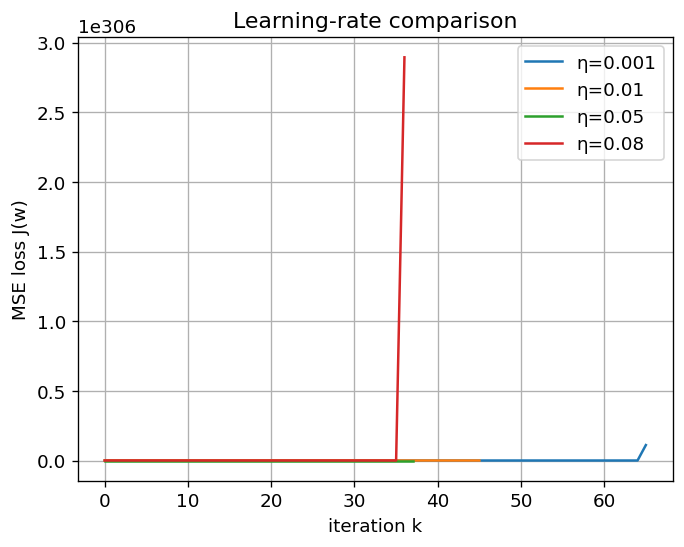

w* for scaled x: [0.005 0.9  ]


In [59]:

# Optional exploration: uncomment to try
x2 = 100 * x
X2 = np.hstack([x2, np.ones_like(x2)])
w0 = np.array([[0.0],[0.0]])
etas2 = [1e-7, 1e-6, 5e-6] ###, 1e-4] ###, 2e-4] ####, 0.01]
histories2 = {}
for eta in etas:
    w_hat, hist = gradient_descent(w0, X2, y, eta=eta, iters=200)
    histories2[eta] = hist
plot_many_losses(histories2)
w_star2 = normal_equation(X2, y)
print('w* for scaled x:', w_star2.ravel())



## 9. Wrap-up questions
1. In this problem, why does a single global learning rate $\eta$ work reasonably well?

Because the dataset doesn't have multiple gradients that are very different from each other, so the "step size" doesn't need to be adjusted accordingly. It's only got a single feature, and therefore, a single smooth "bowl"

2. Suppose we had many features with very different scales. What would you do before running gradient descent, and why?

You'd want to standardize/scale the features in some way to make them more similar. Otherwise, an $\eta$ that worked for one might dramatically overshoot/undershoot on another.

3. How could you detect and mitigate divergence automatically in an implementation?

Check to see if the error grows dramatically between steps. If it does, then stop the calculations.

4. How does the number of iterations to reach a target loss change as you vary $\eta$? Sketch a rough curve.

With tiny $\eta$ s, the steps are too small and take forever to find the minimum. With mid-size $\eta$, you have a good balance of speed and stability. With too large $\eta$, you end up overshooting the minimum. Therefore, the curve favors mid-valued $\eta$.

<details>
<summary><b>Hint: Worked example at $(w_1,b)=(0,0)$</b></summary>

At $(w_1,b)=(0,0)$ we have $\hat y_i = 0$ for all $i$, so residuals are $r_i = \hat y_i - y_i = -y_i$.

Using the five points $(x_i,y_i)$ = (1,2), (2,1), (3,3), (4,2), (5,4):

| $i$ | $x_i$ | $y_i$ | $\hat y_i$ | $r_i = \hat y_i - y_i$ | $r_i x_i$ |
|---:|---:|---:|---:|---:|---:|
| 1 | 1 | 2 | 0 | -2 | -2 |
| 2 | 2 | 1 | 0 | -1 | -2 |
| 3 | 3 | 3 | 0 | -3 | -9 |
| 4 | 4 | 2 | 0 | -2 | -8 |
| 5 | 5 | 4 | 0 | -4 | -20 |

Therefore $\sum_i r_i = -12$ and $\sum_i r_i x_i = -41$ (with $n=5$). Thus
$$\frac{\partial J}{\partial w_1} = \frac{2}{n} \sum_i r_i x_i = \frac{2}{5}(-41) = -16.4,\qquad \frac{\partial J}{\partial b} = \frac{2}{n} \sum_i r_i = \frac{2}{5}(-12) = -4.8.$$

Also,
$$J(0,0) = \frac{1}{n} \sum_i r_i^2 = \frac{1}{5}(4+1+9+4+16) = \frac{34}{5} = 6.8.$$

For comparison, at the other two guesses:

- $(w_1,b)=(1,0)$: residuals $r_i = x_i - y_i = (-1,\,1,\,0,\,2,\,1)$, so $\sum r_i^2 = 7$ and $J(1,0) = 7/5 = 1.4$.
- $(w_1,b)=(0,1)$: residuals $r_i = 1 - y_i = (-1,\,0,\,-2,\,-1,\,-3)$, so $\sum r_i^2 = 15$ and $J(0,1) = 15/5 = 3$.

Hence $J(1,0) < J(0,1) < J(0,0)$ on this dataset. The negative partials at $(0,0)$ mean the gradient components are negative, so a GD update $w \leftarrow w - \eta\,\nabla J(w)$ will **increase** both $w_1$ and $b$.

</details>


In [60]:
# Verify the worked example numerically
w1, b = 0.0, 0.0
r = w1 * x + b - y
n = x.shape[0]
dJ_dw1 = (2/n) * np.sum(r * x)
dJ_db  = (2/n) * np.sum(r)
J_00 = (1/n) * np.sum(r**2)
J_10 = (1/n) * np.sum((1.0 * x + 0.0 - y)**2)
J_01 = (1/n) * np.sum((0.0 * x + 1.0 - y)**2)
print({'dJ_dw1@00': float(dJ_dw1), 'dJ_db@00': float(dJ_db), 'J(0,0)': float(J_00), 'J(1,0)': float(J_10), 'J(0,1)': float(J_01)})


{'dJ_dw1@00': -16.400000000000002, 'dJ_db@00': -4.800000000000001, 'J(0,0)': 6.800000000000001, 'J(1,0)': 1.4000000000000001, 'J(0,1)': 3.0}


## 10) Aside: Nonconvex example — GD can get stuck in a local minimum
Linear regression with MSE is **convex**, so gradient descent converges to the **global** minimizer.
To see how things can differ for **nonconvex** objectives, consider the 1D function
$$f(z) = z^2 + 3\,\sin(2z).$$
This has **many** local minima and maxima. Gradient descent with a fixed step size will typically converge to a
local minimizer in the basin of attraction of the initialization $z_0$.

> **Goal:** Try different starting points and step sizes to see GD land in **different local minima**.


In [61]:
# Nonconvex 1D function and its derivative
import numpy as np
import matplotlib.pyplot as plt

def f(z):
    return z**2 + 3*np.sin(2*z)

def fprime(z):
    return 2*z + 6*np.cos(2*z)

def gd_1d(z0, eta=0.05, iters=60):
    z = float(z0)
    traj = [z]
    vals = [f(z)]
    for k in range(iters):
        z = z - eta * fprime(z)
        traj.append(z)
        vals.append(f(z))
    return np.array(traj), np.array(vals)

def plot_f_with_traj(ztraj_list, labels=None, xlim=(-6,6)):
    xs = np.linspace(xlim[0], xlim[1], 800)
    ys = f(xs)
    fig, ax = plt.subplots()
    ax.plot(xs, ys, 'k-', alpha=0.8, label='f(z)')
    colors = plt.cm.tab10.colors
    for i, zt in enumerate(ztraj_list):
        c = colors[i % len(colors)]
        ax.plot(zt, f(zt), 'o-', color=c, ms=3, lw=1, label=(labels[i] if labels else f'traj {i+1}'))
    ax.set_xlim(*xlim)
    ax.set_xlabel('z')
    ax.set_ylabel('f(z)')
    ax.set_title('Nonconvex f(z) with GD trajectories')
    ax.legend()
    plt.show()


### Exercise 4 — Different starting points lead to different minima
Run GD from several initializations and compare endpoints. Try step sizes like $\eta\in\{0.02, 0.05, 0.1\}$.
Which starts converge to the **same** local minimum? Which go to **different** ones?


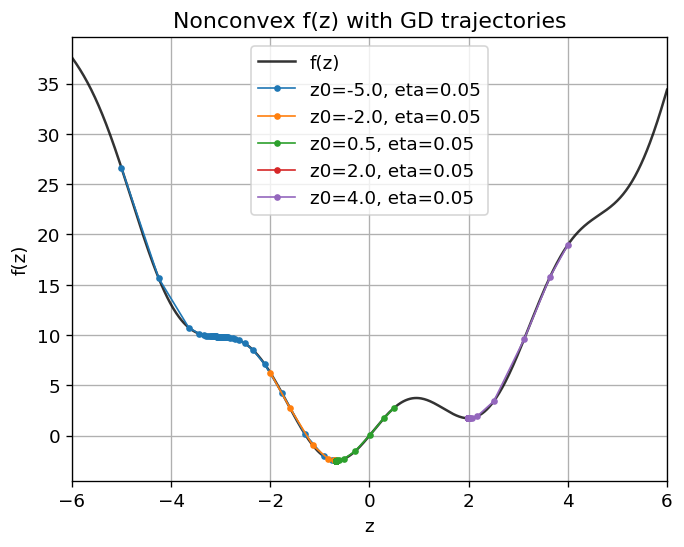

z0= -5.0 -> final z≈-0.6724,  f≈-2.4716
z0= -2.0 -> final z≈-0.6724,  f≈-2.4716
z0=  0.5 -> final z≈-0.6724,  f≈-2.4716
z0=  2.0 -> final z≈ 1.9929,  f≈ 1.7293
z0=  4.0 -> final z≈ 1.9929,  f≈ 1.7293


In [69]:
# Try a few initializations and step sizes (uncomment to experiment)
inits = [-5.0, -2.0, 0.5, 2.0, 4.0]
eta = 0.05      ### try others
ztrajs = []
labels = []
for z0 in inits:
    ztraj, vals = gd_1d(z0, eta=eta, iters=80)
    ztrajs.append(ztraj)
    labels.append(f'z0={z0}, eta={eta}')
plot_f_with_traj(ztrajs, labels)
for z0, ztraj in zip(inits, ztrajs):
    print(f'z0={z0:5.1f} -> final z≈{ztraj[-1]: .4f},  f≈{f(ztraj[-1]): .4f}')


**Notes.**
- In **convex** problems like least-squares, *every* local minimum is global, so GD won't get trapped.
- For **nonconvex** objectives like the $f(z)$ above (or many deep-learning losses), GD can converge to a local minimum near the start point.
- Practical tricks include multiple random restarts, momentum, and better initialization heuristics.


### 10.1. Random restarts to approximate the global minimum
Even in 1D, nonconvex functions can have many local minima. A simple and common heuristic is to run **multiple random restarts** and keep the best solution you find.

We'll sample several random initializations $z_0$ in an interval (e.g., $[-6,6]$), run gradient descent from each, and track the best final value. We'll also do a coarse grid scan for comparison.


{'best_restart': {'z0': -0.7334587229753722, 'z_final': -0.6723755226878945, 'f_final': -2.471592253410668}, 'coarse_grid': {'z_min': -0.6736684171042757, 'f_min': -2.4715808055925086}}


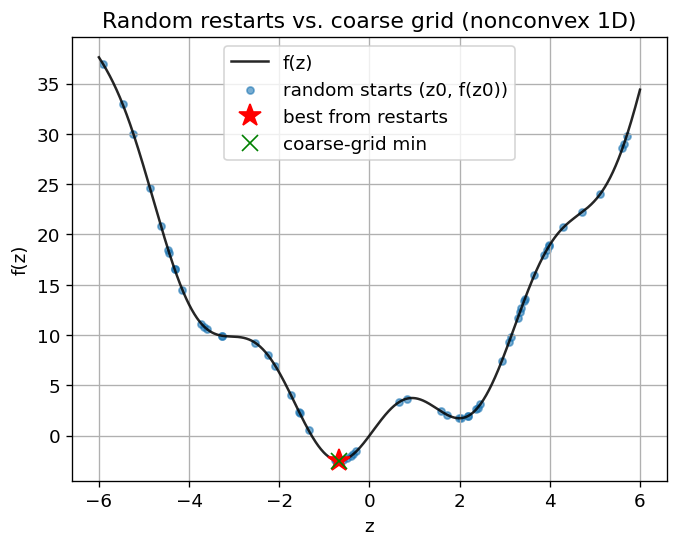

In [74]:
import numpy as np
import matplotlib.pyplot as plt

def random_restart_gd(bounds=(-6.0, 6.0), eta=0.05, iters=120, restarts=50, seed=0):
    rng = np.random.default_rng(seed)
    zs0 = rng.uniform(bounds[0], bounds[1], size=restarts)
    finals = []
    for z0 in zs0:
        ztraj, vals = gd_1d(z0, eta=eta, iters=iters)
        finals.append((ztraj[-1], vals[-1], z0))
    finals.sort(key=lambda t: t[1])  # sort by final f value
    best_z, best_f, best_z0 = finals[0]
    return best_z, best_f, best_z0, zs0, finals

def coarse_grid_min(bounds=(-6.0, 6.0), num=4000):
    xs = np.linspace(bounds[0], bounds[1], num)
    ys = f(xs)
    idx = int(np.argmin(ys))
    return xs[idx], ys[idx]

# Demo: random restarts vs coarse grid (feel free to tweak hyperparameters)
eta = 0.05
best_z, best_f, best_z0, zs0, finals = random_restart_gd(bounds=(-6,6), eta=eta, iters=200, restarts=60, seed=42)
grid_z, grid_f = coarse_grid_min(bounds=(-6,6), num=4000)
print({'best_restart': {'z0': float(best_z0), 'z_final': float(best_z), 'f_final': float(best_f)},
       'coarse_grid': {'z_min': float(grid_z), 'f_min': float(grid_f)}})

# Visualize: function curve, random start points, and best found
xs = np.linspace(-6, 6, 800)
ys = f(xs)
fig, ax = plt.subplots()
ax.plot(xs, ys, 'k-', alpha=0.85, label='f(z)')
ax.scatter(zs0, f(zs0), s=18, c='tab:blue', alpha=0.6, label='random starts (z0, f(z0))')
ax.plot(best_z, best_f, 'r*', ms=14, label='best from restarts')
ax.plot(grid_z, grid_f, 'gx', ms=10, label='coarse-grid min')
ax.set_xlabel('z')
ax.set_ylabel('f(z)')
ax.set_title('Random restarts vs. coarse grid (nonconvex 1D)')
ax.legend()
plt.show()


**Questions.**
1. Does the best random-restart solution approximately match the coarse-grid minimum? If not, increase the number of restarts or iterations.

Yes, it does.

2. Try different step sizes $\eta$ (e.g., 0.02, 0.05, 0.1). Do you notice sensitivity to $\eta$ in which local minimum you land?

Not as much as before -- they all seem to find the coarse-grid minimum.

3. What are pitfalls of random restarts? (e.g., cost, unbounded domains, step-size tuning.)

It takes more time than just running the code once, and you don't actually make the step-size more efficient, so it's more of a quick and easy solution to the problem than the best solution.
